In [111]:
import MySQLdb
import sshtunnel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from ast import literal_eval
import matplotlib.pyplot as plt
import glob
from pathlib import Path
import utils

file_path = Path(get_ipython().run_line_magic('pwd', ''))
data_path = file_path.parent / "app" / "static" / "data"

In [122]:
import json

with open(data_path / "phase_2_statements.js") as f:
    
    json.load(f[])

TypeError: '_io.TextIOWrapper' object is not subscriptable

In [74]:
sshtunnel.SSH_TIMEOUT = 5.0
sshtunnel.TUNNEL_TIMEOUT = 5.0

with sshtunnel.SSHTunnelForwarder(
    ('ssh.pythonanywhere.com'),
    ssh_username='Grawi', ssh_password='midgeq-xikFah-gukpu7',
    remote_bind_address=('Grawi.mysql.pythonanywhere-services.com', 3306)
) as tunnel:
    print("Successfully connected to Pythonanywhere")
    connection = MySQLdb.connect(
        user='Grawi',
        passwd='david2202087',
        host='127.0.0.1', port=tunnel.local_bind_port,
        db='Grawi$Interactive_quiz_database',
    )
    # Do stuff
    print("Successfully connected to database")
    
    try:
        cursor = connection.cursor()
        query = "SELECT * FROM pilot_2 where submit_time>='2024-01-01';"
        df = pd.read_sql(query, connection)
        print(f"Data read finished, length {len(df)}")
    except Exception as e:
        print("Error:", e)
    
    finally:
        # Close the cursor and connection
        cursor.close()
        connection.close()

df["pilot_2_answers"] = df["pilot_2_answers"].map(literal_eval)
df['submit_time'] = pd.to_datetime(df['submit_time'])
df = df.loc[df["participantId"] != "testId"]
df.head()

Successfully connected to Pythonanywhere
Successfully connected to database
Data read finished, length 41


,participantId,assignmentId,projectId,attention_passed,total_time,pilot_2_answers,ideology_label,bot_detected,submit_time,identity_choices,ideologies,reason
0,01D7025D80B743ABA0E82D976A3742B1,50ae4605-7043-4184-a345-b8312d6fa14a,7cc7f6f8-ec89-4df4-b229-6ca392644915,1,376.230,"[{'answer': -1, 'idx_of_question': 5}, {'answe...",-1.0,None,2024-01-09 07:42:02,None,None,None
1,0ED83422D6474D4FB61C995A7C79559B,fcf287ab-ec55-48ac-911f-c01a8230e3a2,7cc7f6f8-ec89-4df4-b229-6ca392644915,1,289.569,"[{'answer': 1.1, 'idx_of_question': 7}, {'answ...",-2.0,None,2024-01-14 05:53:35,None,None,None
2,0F8F309B96464B85B860E8D4F8F32BF8,b80c01df-0ce7-49dd-b02c-a0ee424faf55,7cc7f6f8-ec89-4df4-b229-6ca392644915,1,152.227,"[{'answer': -1.4, 'idx_of_question': 5}, {'ans...",0.1,None,2024-01-14 05:52:59,None,None,None
3,204AEB81228D4911B19E71F42197FEAF,4099048d-b9ea-4157-9da2-ee2b39cc39d3,7cc7f6f8-ec89-4df4-b229-6ca392644915,1,137.327,"[{'answer': -0.9, 'idx_of_question': 7}, {'ans...",1.4,None,2024-01-14 05:59:35,None,None,None
4,23EB7891621447268A92919CB45C6991,7725ebf0-c8e9-42ac-8152-5adac6dc50f1,7cc7f6f8-ec89-4df4-b229-6ca392644915,1,131.702,"[{'answer': 2.2, 'idx_of_question': 6}, {'answ...",1.6,None,2024-01-09 07:41:49,None,None,None


In [75]:
df["ideology_label"] = df.apply(lambda row: row["ideology_label"] if row["submit_time"] >= pd.to_datetime("2024-01-09") else row["ideology_label"] - 2, axis=1)

ids_attention_failed = df.loc[df['attention_passed'] == 0]["participantId"].tolist()
print(f"Participants who failed attention check: {ids_attention_failed}")
df = df.loc[:, ["participantId", "pilot_2_answers", "ideology_label"]].set_index("participantId")

def IdeologyToNumber(ideology):
    if ideology == "Moderate":
        return 0
    elif ideology == "Somewhat Conservative":
        return 1
    elif ideology == "Conservative":
        return 2
    elif ideology == "Somewhat Liberal": 
        return -1
    elif ideology == "Liberal":
        return -2

connect_data_csv = glob.glob('data/connect_raw_data/pilot_2_2*.csv')[0]
df_connect = pd.read_csv(connect_data_csv).set_index("ParticipantId")
df["connect_ideology"] = df_connect["Political Ideology"].map(IdeologyToNumber)
print("rmse of ideology:", np.sqrt(np.mean((df["ideology_label"] - df["connect_ideology"])**2)))
df["ideology"] = df["ideology_label"]
df.drop(["connect_ideology", "ideology_label"], axis=1, inplace=True)
df.head()

Participants who failed attention check: []
rmse of ideology: 0.8804828220925153


,pilot_2_answers,ideology
participantId,,
01D7025D80B743ABA0E82D976A3742B1,"[{'answer': -1, 'idx_of_question': 5}, {'answe...",-1.0
0ED83422D6474D4FB61C995A7C79559B,"[{'answer': 1.1, 'idx_of_question': 7}, {'answ...",-2.0
0F8F309B96464B85B860E8D4F8F32BF8,"[{'answer': -1.4, 'idx_of_question': 5}, {'ans...",0.1
204AEB81228D4911B19E71F42197FEAF,"[{'answer': -0.9, 'idx_of_question': 7}, {'ans...",1.4
23EB7891621447268A92919CB45C6991,"[{'answer': 2.2, 'idx_of_question': 6}, {'answ...",1.6


## 数据分析
### 0. 需要分析什么
1. 每个问题的答案分布
   - 画频方图（分布）
   - 均值
   - 方差
   - 和意识形态的相关系数
2. 每个问题在主题中的次序对它的影响
   - 均值
   - 方差

### 1. 每个问题的答案分布

In [76]:
def IndexToType(index):
    if index >= 0 and index <= 3:
        return "prediction"
    elif index >= 4 and index <= 7:
        return "issue"
    elif index == 8 or index == 9:
        return "fact"

answers = {"index": [], "seq": [], "answer": [], "ideology": []}
for id, row in df.iterrows():
    pilot_2_answers = row["pilot_2_answers"]
    ideology = row["ideology"]
    tmp_seq = {"prediction": 0, "issue": 0, "fact": 0}
    for each_answer in pilot_2_answers:
        answers["index"].append(each_answer["idx_of_question"])
        answers["answer"].append(each_answer["answer"])
        answers["ideology"].append(ideology)
        question_type = IndexToType(each_answer["idx_of_question"])
        answers["seq"].append(tmp_seq[question_type])
        tmp_seq[question_type] += 1
    
df_answers = pd.DataFrame(answers)
df_answers.head()

,index,seq,answer,ideology
0,5,0,-1.0,-1.0
1,3,0,-1.0,-1.0
2,7,1,2.1,-1.0
3,2,1,-1.9,-1.0
4,4,2,-1.9,-1.0


In [85]:
# 均值
df_answers.groupby("index")["answer"].mean()

index
0    0.577500
1    0.050000
2    1.340000
3   -0.507500
4   -0.135000
5   -0.205000
6   -0.340000
7    0.100000
8    0.261667
9    0.433750
Name: answer, dtype: float64

In [98]:
def CalCorrelation(ind_1, ind_2):
    df_1 = df_answers.loc[df_answers["index"] == ind_1]
    df_2 = df_answers.loc[df_answers["index"] == ind_2]
    result = pearsonr(df_1["answer"], df_2["answer"])
    return result[0], result[1]

CalCorrelation(1, 3)
# CalCorrelation(1, 2)

(0.8050227310306516, 3.80655148781519e-10)

In [62]:
# 方差
df_answers.groupby("index")["answer"].std()

index
0    1.673037
1    1.711694
2    1.703371
3    1.689059
4    2.079037
5    1.857354
6    1.783927
7    1.603155
8    1.777636
9    1.790479
Name: answer, dtype: float64

In [78]:
# 和意识形态的相关系数
df_answers.groupby("index").apply(lambda x: pearsonr(x["answer"], x["ideology"])[0])

index
0   -0.017284
1    0.223924
2    0.345271
3    0.289958
4    0.307351
5    0.054560
6    0.237549
7   -0.012732
8    0.011274
9    0.224918
dtype: float64

index
0    <matplotlib.collections.PathCollection object ...
1    <matplotlib.collections.PathCollection object ...
2    <matplotlib.collections.PathCollection object ...
3    <matplotlib.collections.PathCollection object ...
4    <matplotlib.collections.PathCollection object ...
5    <matplotlib.collections.PathCollection object ...
6    <matplotlib.collections.PathCollection object ...
7    <matplotlib.collections.PathCollection object ...
8    <matplotlib.collections.PathCollection object ...
9    <matplotlib.collections.PathCollection object ...
dtype: object

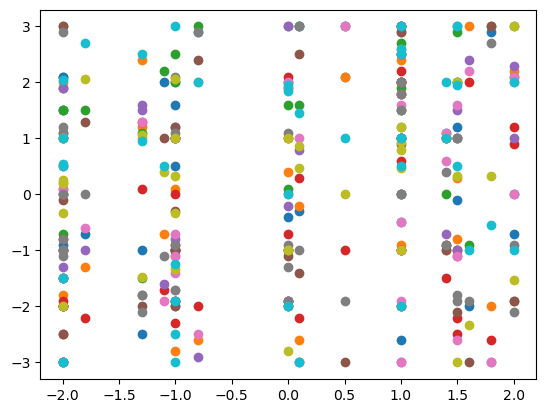

In [79]:
# 画图
df_answers.groupby("index").apply(lambda x: plt.scatter(x["ideology"], x["answer"]))

### 2. 每个问题的次序对它的影响

In [89]:
df_answers.groupby("seq")["answer"].mean(), df_answers.groupby("seq")["answer"].agg(len)

(seq
 0    0.022222
 1    0.408750
 2   -0.103750
 3    0.245000
 Name: answer, dtype: float64,
 seq
 0    120
 1    120
 2     80
 3     80
 Name: answer, dtype: int64)

In [87]:
df_answers.groupby(["index", "seq"])["answer"].mean()
# df_answers.groupby(["index", "seq"])["answer"].agg(len)

index  seq
0      0     -0.520000
       1      0.938462
       2      0.293333
       3      1.300000
1      0     -0.088889
       1      0.787500
       2     -1.400000
       3      0.194444
2      0      0.938462
       1      1.661538
       2      1.400000
       3      1.422222
3      0     -0.192308
       1     -0.183333
       2     -0.526667
       3     -1.466667
4      0     -1.400000
       1     -0.125000
       2     -0.053333
       3      1.966667
5      0     -0.514286
       1     -0.491667
       2      0.437500
       3     -0.169231
6      0      0.080000
       1     -0.200000
       2     -0.477778
       3     -0.691667
7      0      0.341667
       1      0.127273
       2     -0.400000
       3      0.188889
8      0      0.261667
9      1      0.433750
Name: answer, dtype: float64

In [68]:
df_answers.groupby(["index", "seq"])["answer"].std()

index  seq
0      0      2.081666
       1      1.889822
       2      1.438584
       3      1.342882
1      0      3.676955
       1      0.864292
       2      3.959798
       3      1.417809
2      0      1.640207
       1      1.860108
       2      0.141421
       3      1.881489
3      0      1.998416
       1      2.264950
       2      1.627455
       3      0.070711
4      0      0.852447
       1      1.920720
       2      2.318251
       3      0.424264
5      0      1.867619
       1      1.897103
       2      1.256981
       3      2.101666
6      0      1.767295
       1      2.203028
       2      2.284440
       3      1.397447
7      0      1.540454
       1      1.253566
       2      0.777817
       3      1.213947
8      0      1.777636
9      1      1.790479
Name: answer, dtype: float64